In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Convolutional Networks

So far we have worked with deep fully connected networks, using them to explore different optimization strategies and network architectures. Fully connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [12]:
# Setup cell.
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


# Convolution: Naive Forward Pass
The core of a convolutional network is the convolution operation. In the file `cs231n/layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [19]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


## Aside: Image Processing via Convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

In [ ]:
from imageio import imread
from PIL import Image

kitten = imread('cs231n/notebook_images/kitten.jpg')
puppy = imread('cs231n/notebook_images/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = np.array(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = np.array(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resized_puppy.transpose((2, 0, 1))
x[1, :, :, :] = resized_kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

# Convolution: Naive Backward Pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `cs231n/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [21]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.7808556723954787e-08
dw error:  3.2738772890979675e-10
db error:  4.473566414430221e-11


# Max-Pooling: Naive Forward Pass
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `cs231n/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [22]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# Max-Pooling: Naive Backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs231n/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [23]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


# Fast Layers

Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `cs231n/fast_layers.py`.

### Execute the below cell, save the notebook, and restart the runtime
The fast convolution implementation depends on a Cython extension; to compile it, run the cell below. Next, save the Colab notebook (`File > Save`) and **restart the runtime** (`Runtime > Restart runtime`). You can then re-execute the preceeding cells from top to bottom and skip the cell below as you only need to run it once for the compilation step.

In [26]:
# Remember to restart the runtime after executing this cell!
%cd cs231n
!python setup.py build_ext --inplace
%cd ..

/Users/arjuns/Downloads/cnn/assignment2/cs231n
Compiling im2col_cython.pyx because it changed.
[1/1] Cythonizing im2col_cython.pyx
/Users/arjuns/Downloads/cnn/jupyter_env/lib/python3.10/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/arjuns/Downloads/cnn/assignment2/cs231n/im2col_cython.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from im2col_cython.c:1249:
In file included from /Users/arjuns/Downloads/cnn/jupyter_env/lib/python3.10/site-packages/numpy/_core/include/numpy/arrayobject.h:5:
In file included from /Users/arjuns/Downloads/cnn/jupyter_env/lib/python3.10/site-packages/numpy/_core/include/numpy/ndarrayobject.h:12:
In file included from /Users/arjuns/Downloads/cnn/jupyter_env/lib/python3.10/site-packages/numpy/_core/include/numpy/ndarraytypes.h:1909:
/Users/arjuns/Downloads/cnn/jupyter_env/lib/python3.10/site-packages/

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**Note:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [3]:
# Rel errors should be around e-9 or less.
from cs231n.fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 2.557254s
Fast: 0.007760s
Speedup: 329.551172x
Difference:  7.88225256277888e-11

Testing conv_backward_fast:
Naive: 3.682419s
Fast: 0.006374s
Speedup: 577.735655x
dx difference:  1.50193951894836e-11
dw difference:  5.810575408376625e-13
db difference:  7.091648286133121e-14


In [4]:
# Relative errors should be close to 0.0.
from cs231n.fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.220705s
fast: 0.002499s
speedup: 88.313681x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.308985s
fast: 0.008888s
speedup: 34.764237x
dx difference:  0.0


# Convolutional "Sandwich" Layers
In the previous assignment, we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `cs231n/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks. Run the cells below to sanity check their usage.

In [5]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  1.3129103487372312e-08
dw error:  4.243260484602694e-09
db error:  3.579585075287619e-10


In [6]:
from cs231n.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  5.532043677351017e-09
dw error:  2.556001426075349e-10
db error:  1.1891655515776076e-10


# Three-Layer Convolutional Network
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Remember you can use the fast/sandwich layers (already imported for you) in your implementation. Run the following cells to help you debug:

## Sanity Check Loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [20]:
from cs231n.classifiers.cnn import ThreeLayerConvNet

model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3025848138049096
Initial loss (with regularization):  2.5085429566815347


## Gradient Check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [21]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(
    num_filters=3,
    filter_size=3,
    input_dim=input_dim,
    hidden_dim=7,
    dtype=np.float64
)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.053965e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.422399e-04
b1 max relative error: 3.397321e-06
b2 max relative error: 2.517459e-03
b3 max relative error: 9.711800e-10


## Overfit Small Data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [22]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(
    model,
    small_data,
    num_epochs=15,
    batch_size=50,
    update_rule='adam',
    optim_config={'learning_rate': 1e-3,},
    verbose=True,
    print_every=1
)
solver.train()

(Iteration 1 / 30) loss: 2.414060
(Epoch 0 / 15) train acc: 0.200000; val_acc: 0.137000
(Iteration 2 / 30) loss: 3.102925
(Epoch 1 / 15) train acc: 0.140000; val_acc: 0.087000
(Iteration 3 / 30) loss: 2.270330
(Iteration 4 / 30) loss: 2.096705
(Epoch 2 / 15) train acc: 0.240000; val_acc: 0.094000
(Iteration 5 / 30) loss: 1.838880
(Iteration 6 / 30) loss: 1.934188
(Epoch 3 / 15) train acc: 0.510000; val_acc: 0.173000
(Iteration 7 / 30) loss: 1.827912
(Iteration 8 / 30) loss: 1.639574
(Epoch 4 / 15) train acc: 0.520000; val_acc: 0.188000
(Iteration 9 / 30) loss: 1.330082
(Iteration 10 / 30) loss: 1.756115
(Epoch 5 / 15) train acc: 0.630000; val_acc: 0.167000
(Iteration 11 / 30) loss: 1.024162
(Iteration 12 / 30) loss: 1.041826
(Epoch 6 / 15) train acc: 0.750000; val_acc: 0.229000
(Iteration 13 / 30) loss: 1.142777
(Iteration 14 / 30) loss: 0.835706
(Epoch 7 / 15) train acc: 0.790000; val_acc: 0.247000
(Iteration 15 / 30) loss: 0.587786
(Iteration 16 / 30) loss: 0.645509
(Epoch 8 / 15) tr

In [23]:
# Print final training accuracy.
print(
    "Small data training accuracy:",
    solver.check_accuracy(small_data['X_train'], small_data['y_train'])
)

Small data training accuracy: 0.82


In [24]:
# Print final validation accuracy.
print(
    "Small data validation accuracy:",
    solver.check_accuracy(small_data['X_val'], small_data['y_val'])
)

Small data validation accuracy: 0.252


Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

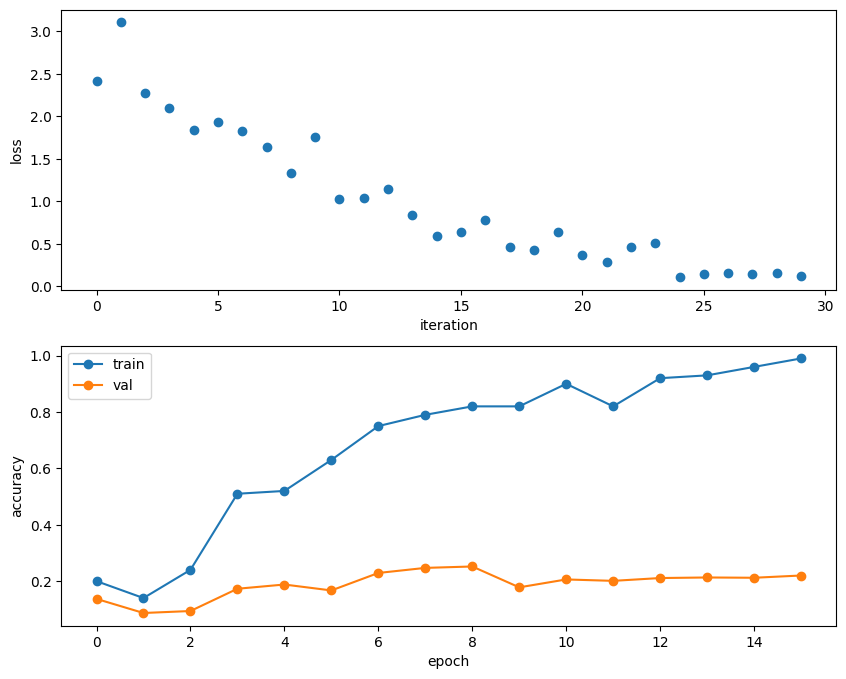

In [25]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the Network
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [26]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(
    model,
    data,
    num_epochs=1,
    batch_size=50,
    update_rule='adam',
    optim_config={'learning_rate': 1e-3,},
    verbose=True,
    print_every=20
)
solver.train()

(Iteration 1 / 980) loss: 2.304740
(Epoch 0 / 1) train acc: 0.103000; val_acc: 0.107000
(Iteration 21 / 980) loss: 2.098229
(Iteration 41 / 980) loss: 1.949788
(Iteration 61 / 980) loss: 1.888398
(Iteration 81 / 980) loss: 1.877093
(Iteration 101 / 980) loss: 1.851877
(Iteration 121 / 980) loss: 1.859353
(Iteration 141 / 980) loss: 1.800181
(Iteration 161 / 980) loss: 2.143292
(Iteration 181 / 980) loss: 1.830573
(Iteration 201 / 980) loss: 2.037280
(Iteration 221 / 980) loss: 2.020304
(Iteration 241 / 980) loss: 1.823728
(Iteration 261 / 980) loss: 1.692679
(Iteration 281 / 980) loss: 1.882594
(Iteration 301 / 980) loss: 1.798261
(Iteration 321 / 980) loss: 1.851960
(Iteration 341 / 980) loss: 1.716323
(Iteration 361 / 980) loss: 1.897655
(Iteration 381 / 980) loss: 1.319744
(Iteration 401 / 980) loss: 1.738790
(Iteration 421 / 980) loss: 1.488866
(Iteration 441 / 980) loss: 1.718409
(Iteration 461 / 980) loss: 1.744440
(Iteration 481 / 980) loss: 1.605460
(Iteration 501 / 980) loss: 

In [31]:
# Print final training accuracy.
print(
    "Full data training accuracy:",
    solver.check_accuracy(data['X_train'], data['y_train'])
)

Full data training accuracy: 0.4761836734693878


In [32]:
# Print final validation accuracy.
print(
    "Full data validation accuracy:",
    solver.check_accuracy(data['X_val'], data['y_val'])
)

Full data validation accuracy: 0.499


## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

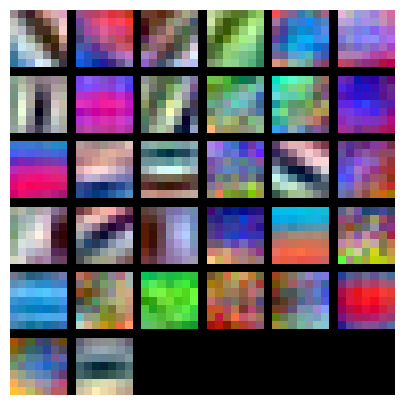

In [29]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully connected networks. As proposed in the original paper (link in `BatchNormalization.ipynb`), batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally, batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect every feature channel's statistics e.g. mean, variance to be relatively consistent both between different images, and different locations within the same image -- after all, every feature channel is produced by the same convolutional filter! Therefore, spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over the minibatch dimension `N` as well the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

# Spatial Batch Normalization: Forward Pass

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [33]:
np.random.seed(231)

# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization.
N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  shape: ', x.shape)
print('  means: ', x.mean(axis=(0, 2, 3)))
print('  stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  shape: ', out.shape)
print('  means: ', out.mean(axis=(0, 2, 3)))
print('  stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  shape: ', out.shape)
print('  means: ', out.mean(axis=(0, 2, 3)))
print('  stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  shape:  (2, 3, 4, 5)
  means:  [9.33463814 8.90909116 9.11056338]
  stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  shape:  (2, 3, 4, 5)
  means:  [ 5.96744876e-16  5.55111512e-16 -1.72084569e-16]
  stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  shape:  (2, 3, 4, 5)
  means:  [6. 7. 8.]
  stds:  [2.99999885 3.99999804 4.99999798]


In [34]:
np.random.seed(231)

# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]


# Spatial Batch Normalization: Backward Pass
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [35]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.786648192901616e-07
dgamma error:  7.0969976381299756e-12
dbeta error:  3.2754947613321483e-12


# Spatial Group Normalization
In the previous notebook, we mentioned that Layer Normalization is an alternative normalization technique that mitigates the batch size limitations of Batch Normalization. However, as the authors of [2] observed, Layer Normalization does not perform as well as Batch Normalization when used with Convolutional Layers:

>With fully connected layers, all the hidden units in a layer tend to make similar contributions to the final prediction, and re-centering and rescaling the summed inputs to a layer works well. However, the assumption of similar contributions is no longer true for convolutional neural networks. The large number of the hidden units whose
receptive fields lie near the boundary of the image are rarely turned on and thus have very different
statistics from the rest of the hidden units within the same layer.

The authors of [3] propose an intermediary technique. In contrast to Layer Normalization, where you normalize over the entire feature per-datapoint, they suggest a consistent splitting of each per-datapoint feature into G groups and a per-group per-datapoint normalization instead. 

<p align="center">
<img src="https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/a2/normalization.png">
</p>
<center>Visual comparison of the normalization techniques discussed so far (image edited from [3])</center>

Even though an assumption of equal contribution is still being made within each group, the authors hypothesize that this is not as problematic, as innate grouping arises within features for visual recognition. One example they use to illustrate this is that many high-performance handcrafted features in traditional computer vision have terms that are explicitly grouped together. Take for example Histogram of Oriented Gradients [4] -- after computing histograms per spatially local block, each per-block histogram is normalized before being concatenated together to form the final feature vector.

You will now implement Group Normalization.

[2] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)


[3] [Wu, Yuxin, and Kaiming He. "Group Normalization." arXiv preprint arXiv:1803.08494 (2018).](https://arxiv.org/abs/1803.08494)


[4] [N. Dalal and B. Triggs. Histograms of oriented gradients for
human detection. In Computer Vision and Pattern Recognition
(CVPR), 2005.](https://ieeexplore.ieee.org/abstract/document/1467360/)

# Spatial Group Normalization: Forward Pass

In the file `cs231n/layers.py`, implement the forward pass for group normalization in the function `spatial_groupnorm_forward`. Check your implementation by running the following:

In [36]:
np.random.seed(231)

# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization.
N, C, H, W = 2, 6, 4, 5
G = 2
x = 4 * np.random.randn(N, C, H, W) + 10
x_g = x.reshape((N*G,-1))
print('Before spatial group normalization:')
print('  shape: ', x.shape)
print('  means: ', x_g.mean(axis=1))
print('  stds: ', x_g.std(axis=1))

# Means should be close to zero and stds close to one
gamma, beta = np.ones((1,C,1,1)), np.zeros((1,C,1,1))
bn_param = {'mode': 'train'}

out, _ = spatial_groupnorm_forward(x, gamma, beta, G, bn_param)
out_g = out.reshape((N*G,-1))
print('After spatial group normalization:')
print('  shape: ', out.shape)
print('  means: ', out_g.mean(axis=1))
print('  stds: ', out_g.std(axis=1))

Before spatial group normalization:
  shape:  (2, 6, 4, 5)
  means:  [9.72505327 8.51114185 8.9147544  9.43448077]
  stds:  [3.67070958 3.09892597 4.27043622 3.97521327]
After spatial group normalization:
  shape:  (2, 6, 4, 5)
  means:  [ 2.62752782e-16  4.66293670e-16  2.72929827e-16 -3.68223970e-16]
  stds:  [0.99999963 0.99999948 0.99999973 0.99999968]


# Spatial Group Normalization: Backward Pass
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_groupnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [41]:
np.random.seed(231)
N, C, H, W = 2, 6, 4, 5
G = 2
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(1,C,1,1)
beta = np.random.randn(1,C,1,1)
dout = np.random.randn(N, C, H, W)

gn_param = {}
fx = lambda x: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fg = lambda a: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fb = lambda b: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_groupnorm_forward(x, gamma, beta, G, gn_param)
dx, dgamma, dbeta = spatial_groupnorm_backward(dout, cache)

# You should expect errors of magnitudes between 1e-12 and 1e-07. 
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  6.616282929917622e-08
dgamma error:  2.654087320745512e-12
dbeta error:  4.561741924465385e-12
